# Подключение библиотек

In [ ]:
import numpy as np
import pandas as pd

# Реализация многоруких бандитов

### UCB

In [ ]:
class UCBSamplingReplayer():
    def __init__(self,ucb_c, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name):
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.ucb_c = ucb_c

        self.n_visits = n_visits

        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
        self.Q = np.zeros(self.n_items)
        self.N = np.zeros(self.n_items) + 0.0001
        self.timestep = 1


    def select_item(self):
        ln_timestep = np.log(np.full(self.n_items, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)

        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        
        return action

    def record_result(self, visit, item_idx, reward):
        self.N[item_idx] += 1
        self.Q[item_idx] += 1/self.N[item_idx] * (reward - self.Q[item_idx])


    def simulate(self):
        results = []
        
        self.reset()
        
        total_rewards = 0
        fraction_relevant = np.zeros(self.n_visits)

        for visit in range(0, self.n_visits):
        
            found_match = False
            while not found_match:
            
                visitor_idx = np.random.randint(self.n_visitors)
                visitor_id = self.visitors[visitor_idx]

                item_idx = self.select_item()
                item_id = self.items[item_idx]
                
                reward = self.reward_history.query(
                    '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                
                found_match = reward.shape[0] > 0
            
            reward_value = reward.iloc[0]
            
            self.record_result(visit, item_idx, reward_value)

            total_rewards += reward_value
            fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
            
            result = {}
            result['visit'] = visit
            result['item_id'] = item_id
            result['visitor_id'] = visitor_id
            result['reward'] = reward_value
            result['total_reward'] = total_rewards
            result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
            
            results.append(result)
        
        return results

### Epsilon-Greedy

In [ ]:
class EpsilonGreedyReplayer():
    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name):
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
    
        self.epsilon = epsilon

        self.n_visits = n_visits

        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
    
    def select_item(self):
        if np.random.uniform() < self.epsilon:
            item_id = np.random.randint(self.n_items)
            
        else: 
            item_id = np.argmax(self.n_item_rewards)
            
        return item_id
    
    def reset(self):
        self.n_item_samples = np.zeros(self.n_items)
        
        self.n_item_rewards = np.zeros(self.n_items)

    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])
    
    def simulate(self):
        results = []
        
        self.reset()
        
        total_rewards = 0
        fraction_relevant = np.zeros(self.n_visits)

        for visit in range(0, self.n_visits):
        
            found_match = False
            while not found_match:
            
                visitor_idx = np.random.randint(self.n_visitors)
                visitor_id = self.visitors[visitor_idx]

                item_idx = self.select_item()
                item_id = self.items[item_idx]
                
                reward = self.reward_history.query(
                    '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                
                found_match = reward.shape[0] > 0
            
            reward_value = reward.iloc[0]
            
            self.record_result(visit, item_idx, reward_value)
            
            total_rewards += reward_value
            fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
            
            result = {}
            result['visit'] = visit
            result['item_id'] = item_id
            result['visitor_id'] = visitor_id
            result['reward'] = reward_value
            result['total_reward'] = total_rewards
            result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
            
            results.append(result)
        
        return results

### Explore first

In [ ]:
class ExploreFirstReplayer():
    def __init__(self, rounds, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name):
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.rounds = rounds
    
        self.n_visits = n_visits

        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
        self.Q = np.zeros(self.n_items)
        self.N = np.zeros(self.n_items) + 0.0001


    def select_item(self):
        action = np.argmax(self.Q)

        return action

    def record_result(self, item_idx, reward):
        self.N[item_idx] += 1
        self.Q[item_idx] += 1/self.N[item_idx] * (reward - self.Q[item_idx])


    def simulate(self):
        results = []
        
        self.reset()
        
        total_rewards = 0
        fraction_relevant = np.zeros(self.n_visits)

        for item_idx in range(0, self.n_items):
            item_id = self.items[item_idx]
            for i in range(self.rounds):
                visitor_idx = np.random.randint(self.n_visitors)
                visitor_id = self.visitors[visitor_idx]
                found_match = False
                while not found_match:
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                        
                    found_match = reward.shape[0] > 0
            
                reward_value = reward.iloc[0]
                self.record_result(item_idx, reward_value)

        for visit in range(0, self.n_visits):
        
            found_match = False
            while not found_match:
            
                visitor_idx = np.random.randint(self.n_visitors)
                visitor_id = self.visitors[visitor_idx]

                item_idx = self.select_item()
                item_id = self.items[item_idx]

                reward = self.reward_history.query(
                    '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                
                found_match = reward.shape[0] > 0
            
            reward_value = reward.iloc[0]

            total_rewards += reward_value
            fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
            
            result = {}
            result['visit'] = visit
            result['item_id'] = item_id
            result['visitor_id'] = visitor_id
            result['reward'] = reward_value
            result['total_reward'] = total_rewards
            result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
            
            results.append(result)
        
        return results

# Подготовка данных

Датасет взят отсюда: https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews


In [ ]:
path = "./Desktop/MABs/"

In [ ]:
df = pd.read_csv(path + 'ratings_electronics.csv', names=["User_ID", "Product_ID", "Rating", "Time_Stamp"])

In [ ]:
reward_threshold = 4

In [ ]:
df['Reward'] = df.eval('Rating > @reward_threshold').astype(int)

In [ ]:
df

,User_ID,Product_ID,Rating,Time_Stamp,Reward
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200,1
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,1
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,0
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,0
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,0
...,...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600,1
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400,1
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800,0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200,0


In [ ]:
n_visits = 500

In [ ]:
reward_history = df[:1000]

In [ ]:
item_col_name     = 'Product_ID'
visitor_col_name  = 'User_ID'
reward_col_name   = 'Reward'

# Запуск UCB

Обычно симуляцию проводит довольно долго. В районе 4 минут на Ryzen 5600.

In [ ]:
%%time
ucb = 2

ucb_results = UCBSamplingReplayer(ucb, n_visits, reward_history,
                                  item_col_name, visitor_col_name, 
                                  reward_col_name).simulate()

ucb_results_df = pd.DataFrame(ucb_results)

CPU times: total: 3min 47s
Wall time: 3min 52s


In [ ]:
ucb_results_df

,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0132793040,AKM1MP6P0OYPR,1,1,1.000000
1,1,0321732944,A2CX7LUOHB2NDG,1,2,1.000000
2,2,0439886341,A1GI0U4ZRJA8WN,0,2,0.666667
3,3,0511189877,A3J3BRHTDRFJ2G,0,2,0.500000
4,4,0528881469,A2XSWV6AQI90BR,0,2,0.400000
...,...,...,...,...,...,...
495,495,0594287995,A34TPQUVSQXXPX,1,324,0.653226
496,496,0594450209,A244IAP7UBVHH6,1,325,0.653924
497,497,0594450705,A3E7PG9CHDBICA,1,326,0.654618
498,498,0594511488,A32JHAQPVSGHUD,1,327,0.655311


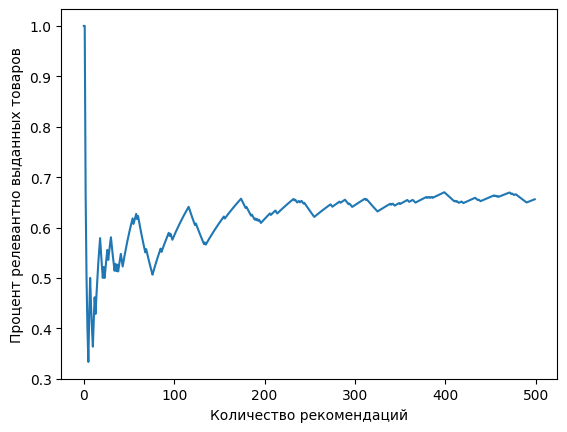

In [ ]:
ucb_results_df['fraction_relevant'].plot(xlabel="Количество рекомендаций",
                                         ylabel="Процент релевантно выданных товаров")
None

Итоговый процент релевантно выданных товаров:

In [ ]:
ucb_results_df['fraction_relevant'].values[-1]

0.656

# Запуск Epsilon-Greedy

Обычно симуляцию проводит довольно долго. В районе 3 минут на Ryzen 5600.

In [ ]:
%%time
epsilon = 0.05
eg_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                   item_col_name, visitor_col_name, 
                                   reward_col_name).simulate()

eg_results_df = pd.DataFrame(eg_results)

CPU times: total: 3min 2s
Wall time: 3min 6s


In [ ]:
eg_results_df

,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0132793040,AKM1MP6P0OYPR,1,1,1.000000
1,1,0132793040,AKM1MP6P0OYPR,1,2,1.000000
2,2,0972683275,A3LUBQ6HTHQC9C,0,2,0.666667
3,3,0132793040,AKM1MP6P0OYPR,1,3,0.750000
4,4,0972683275,A1Y7I43UEGKDN7,0,3,0.600000
...,...,...,...,...,...,...
495,495,0972683275,A1DPTFY0G6P7SY,0,392,0.790323
496,496,0972683275,A2683OJ85CLWFA,1,393,0.790744
497,497,0132793040,AKM1MP6P0OYPR,1,394,0.791165
498,498,0972683275,A1BFGWPAR3XE0Y,1,395,0.791583


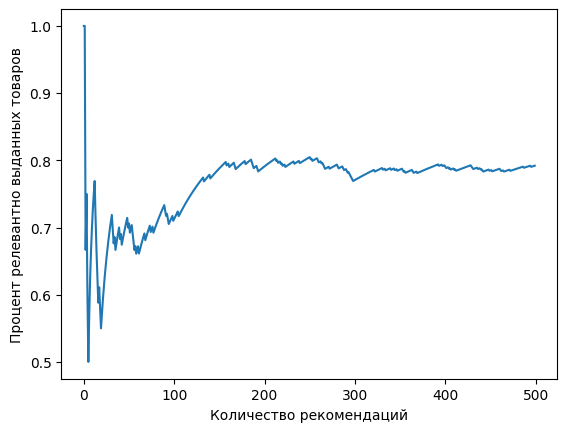

In [ ]:
eg_results_df['fraction_relevant'].plot(xlabel="Количество рекомендаций",
                                        ylabel="Процент релевантно выданных товаров")
None

Итоговый процент релевантно выданных товаров:

In [ ]:
eg_results_df['fraction_relevant'].values[-1]

0.792

# Запуск Exploration First

Обычно симуляцию проводит довольно долго. В районе 7 минут на Ryzen 5600.

In [ ]:
%%time
rounds = 5
ef_results = ExploreFirstReplayer(rounds, n_visits, reward_history,
                                   item_col_name, visitor_col_name, 
                                   reward_col_name).simulate()

ef_results_df = pd.DataFrame(ef_results)

KeyboardInterrupt: ignored

In [ ]:
ef_results_df

NameError: ignored

In [ ]:
ef_results_df['fraction_relevant'].plot(xlabel="Количество рекомендаций",
                                        ylabel="Процент релевантно выданных товаров")
None

Итоговый процент релевантно выданных товаров:

In [ ]:
ef_results_df['fraction_relevant'].values[-1]